# SIR-SEIR Model

## SIR Model

\begin{cases}
    \frac{dS}{dt} = -\frac{\beta S I}{N} \\
    \frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
    \frac{dR}{dt} = \gamma I
\end{cases}

$$
N = S + I + R
$$

## SEIR Model

\begin{cases}
    \frac{dS}{dt} = -\frac{\beta S I}{N} \\
    \frac{dE}{dt} = \frac{\beta S I}{N} - \sigma E \\
    \frac{dI}{dt} = \sigma E - \gamma I \\
    \frac{dR}{dt} = \gamma I
\end{cases}

$$
N = S + E + I + R
$$

## Parameters

And parameters are:

- $\beta$ is infection rate or the rate of spread

- $\sigma$ is the incubation rate or the rate of latent individuals becoming infectious (average duration of incubation is $1/\sigma$)

- $\gamma$ is the recovery rate or mortality rate. If the duration of indection is D then $\gamma$ = 1/D

## Modules and Settings

In [1]:
# Import modules

import os                as os
import warnings

import sys
import time
import arviz             as az
import numpy             as np
import pandas            as pd

import pymc3             as pm
import theano
import theano.tensor     as tt

import matplotlib.pyplot as plt

from scipy.integrate   import odeint
from scipy.interpolate import interp1d

# Further technicalities

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")

# Checking versions

print(f"Theano version: {theano.__version__}")
print(f"PyMC3  version: {pm.__version__}")

Theano version: 1.1.2
PyMC3  version: 3.11.4


In [2]:
from google.colab import drive

from datetime import datetime

drive.mount('/content/gdrive')

now = datetime.now().strftime('%b%d_%H-%M-%S')

folder_name = 'Images/Prova_d' # Se volete cambiare il percorso della cartella modificate questa variable. Esempio: folder_name = 'Progetto_MLMCMC/Prova_Comet_1/Rando/'

dir = os.path.join('/content/gdrive/My Drive/MLMCMC_Project/SIR->SEIR/', folder_name) 

if not os.path.exists(dir):

    os.makedirs(dir)

os.chdir(dir)

Mounted at /content/gdrive


In [3]:
# System

stochastic  = False                 # random seeds for the experiments

RANDOM_SEED = 123456                # sampling seed
NUMPY_SEED  = 123                   # Numpy    seed


# True model 

n_params            = 3             # number of unknown quantities
noise_variance_true = 0.0001        # variance of the gaussian noise on the data

## Initial conditions

initN = 1   # Important!

initE = 0.1
initI = 0.15
initR = 0.

## True values for the parameters

sigma_true = 0.1
gamma_true = 0.1
beta_true  = 0.27

## Days and steps

days = 100                            # total number of days
time_step = 0.5                      # time_step true model, expressed in days (if artificial data is used)


# Models

time_step_models = np.array([1,     0.5]) # time step

system_models    = np.array(['SIR', 'SEIR']) # dynamical system

var_lik          = np.array([0.05,  0.05]) # variance in the likelihood


# Likelihood

plot_likelihood     = True      # plot likelihood at each level
plot_customized_lik = False     # plot likelihood with modified parameter intervals


n_ref_lik   = 50                # precision of the grid for the plot
contour_lik = 20                # number of contour lines in each plot

lower_sigma = 0.01               # lower bound for sigma
upper_sigma = 0.5               # upper bound for sigma

lower_gamma = 0.01               # lower bound for gamma
upper_gamma = 0.3               # upper bound for gamma

lower_beta  = 0.05               # lower bound for beta
upper_beta  = 0.5               # upper bound for beta 



# MCMC Settings

use_MAP_as_start = False       # set True to use MAP as starting point; False uses [beta_0, sigma_0, gamma_0]
sigma_0    = 0.25              # initial guess for sigma unknown parameter
gamma_0    = 0.15              # initial guess for gamma unknown parameter
beta_0     = 0.3              # initial guess for beta  unknown parameter

tune              = True
tune_interval_M   = 100        # set high to prevent tuning
tune_interval_DMZ = 100
discard_tuning    = True


## MH

perform_M    = True     # perform MH sampling

ndraws_M     = 8000     # number of draws from the distribution for MH
nburn_M      = 2000     # number of burn-in samples for MH
nchains_M    = 3        # number of chains for MH


## DemetropolisZ

perform_DMZ  = True     # perform DemetropolisZ sampling

ndraws_DMZ   = 8000     # number of draws from the distribution for DemetropolisZ
nburn_DMZ    = 2000     # number of burn-in samples for DemetropolisZ
nchains_DMZ  = 3        # number of chains for DemetropolisZ


## MLDA with/without VR

perform_MLDA_without_variance_reduction = True    # perform the MLDA sampling without variance reduction
perform_MLDA_with_variance_reduction    = True    # perform the MLDA sampling with    variance reduction

ndraws_MLDA  = 8000     # number of draws from the distribution for MLDA
nburn_MLDA   = 2000     # number of burn-in samples for MLDA
nchains_MLDA = 3        # number of chains for MLDA
nsub_MLDA    = 10        # subsampling rate for MLDA

In [4]:
## Quantities of Interest (QoI)

n_qoi = 2      # number of QoI
qoi_names = [] # 

def QoI(level_i_model):
    
    qoi_names.append("Infections_Peak_Time")
    qoi_names.append("Infections_Peak")

    if(level_i_model.ODE_label == 'SIR'):
        return level_i_model.time_grid[np.argmax(level_i_model.sol[:,1])], np.max(level_i_model.sol[:,1])
    else: # level_i_model.ODE_label == 'SEIR'
        return level_i_model.time_grid[np.argmax(level_i_model.sol[:,2])], np.max(level_i_model.sol[:,2])

In [5]:
# Set seed (in case it's needed)
if(not stochastic):
    np.random.seed(NUMPY_SEED)

# Dynamical Systems

In [6]:
# SIR

def ode_model_SIR(z, t, beta, gamma):
    S, I, R = z
    N = S + I + R
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

def ode_solver_SIR(t, initial_conditions, params):
  initI, initR, initN = initial_conditions
  beta, gamma = params
  initS = initN - (initI + initR)
  res = odeint(ode_model_SIR, [initS, initI, initR], t, args=(beta, gamma))
  return res

# SEIR

def ode_model_SEIR(z, t, beta, sigma, gamma):

    S, E, I, R = z
    N = S + E + I + R
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I
    dRdt = gamma*I
    return [dSdt, dEdt, dIdt, dRdt]

def ode_solver_SEIR(t, initial_conditions, params):
  initE, initI, initR, initN = initial_conditions
  beta, sigma, gamma = params
  initS = initN - (initE + initI + initR)
  res = odeint(ode_model_SEIR, [initS, initE, initI, initR], t, args=(beta, sigma, gamma))
  return res

# Create models and generate data

In [7]:
# SEIR True

class Dynamical_System_SEIR():


  def __init__(self, sigma_true, gamma_true, beta_true, days, time_step, initN, initE, initI, initR, noise_scale):
    
    # Set the quantities related to the true system

    self.sigma = sigma_true
    self.gamma = gamma_true
    self.beta  = beta_true

    # Initial conditions

    self.initN = initN
    self.initE = initE
    self.initI = initI
    self.initR = initR

    self.initial_conditions = [self.initE, self.initI, self.initR, self.initN]
    self.params = [self.beta, self.sigma, self.gamma]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step)

    # Compute solution

    self.sol = ode_solver_SEIR(self.time_grid, self.initial_conditions, self.params)

    # Save solutions and add noise
    
    self.E = self.sol[:,1] + np.random.normal(0,noise_scale, len(self.time_grid))
    self.I = self.sol[:,2] + np.random.normal(0,noise_scale, len(self.time_grid))
    self.R = self.sol[:,3] + np.random.normal(0,noise_scale, len(self.time_grid))

    # Save objects for interpolation

    self.E_interpolated = interp1d(self.time_grid, self.E, kind = "linear")
    self.I_interpolated = interp1d(self.time_grid, self.I, kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.R, kind = "linear")

    self.data = np.column_stack((self.E, self.I, self.R))


  def plot_model(self):

    SEIR_cmap = plt.cm.get_cmap('Set3', 5)(range(5))

    plt.plot(self.time_grid, self.E,          label = "E (SEIR)",    color = SEIR_cmap[1])
    plt.plot(self.time_grid, self.I,          label = "I  (SEIR)",   color = SEIR_cmap[2])
    plt.plot(self.time_grid, self.R,          label = "R (SEIR)",    color = SEIR_cmap[3])
    plt.plot(self.time_grid, self.E + self.I, label = "E+I (SEIR)",  color = SEIR_cmap[4])

    plt.xlabel('time [d]')
    plt.ylabel('population [%]')



# SEIR Forward

class Dynamical_System_Forward_SEIR():


  def __init__(self, days, time_step, initN, initE, initI, initR, var_lik):

    self.ODE_label   = 'SEIR'

    # Initial conditions

    self.initN = initN
    self.initE = initE
    self.initI = initI
    self.initR = initR

    self.initial_conditions = [self.initE, self.initI, self.initR, self.initN]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step)

    # Set variance for likelihood

    self.var_lik = var_lik


  def solve(self, beta_random, sigma_random, gamma_random):

    self.sol = ode_solver_SEIR(self.time_grid, self.initial_conditions, [beta_random, sigma_random, gamma_random])

    self.S_interpolated = interp1d(self.time_grid, self.sol[:,0], kind = "linear")
    self.E_interpolated = interp1d(self.time_grid, self.sol[:,1], kind = "linear")
    self.I_interpolated = interp1d(self.time_grid, self.sol[:,2], kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.sol[:,3], kind = "linear")


  def plot_model(self):
    
    SEIR_cmap = plt.cm.get_cmap('Set2', 5)(range(5))
    
    plt.plot(self.time_grid, self.sol[:,1],                 label = "E (SEIR)",    color = SEIR_cmap[1])
    plt.plot(self.time_grid, self.sol[:,2],                 label = "I  (SEIR)",   color = SEIR_cmap[2])
    plt.plot(self.time_grid, self.sol[:,3],                 label = "R (SEIR)",    color = SEIR_cmap[3])
    plt.plot(self.time_grid, self.sol[:,1] + self.sol[:,2], label = "E+I (SEIR)",  color = SEIR_cmap[4])

    plt.xlabel('time [d]')
    plt.ylabel('population [%]')

  def sol_interpolated(self, times):
    return np.column_stack((self.E_interpolated(times), self.I_interpolated(times), self.R_interpolated(times)))



# SIR Forward

class Dynamical_System_Forward_SIR():


  def __init__(self, days, time_step, initN, initE, initI, initR, var_lik):
    
    self.ODE_label   = 'SIR'

    # Initial conditions

    self.initN = initN
    self.initI = initI+initE
    self.initR = initR

    self.initial_conditions = [self.initI, self.initR, self.initN]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step)

    # Set variance for likelihood

    self.var_lik = var_lik


  def SEIR_to_SIR(self, beta_SEIR, gamma_SEIR, sigma_SEIR):

    beta_SIR  = sigma_SEIR * beta_SEIR  / (sigma_SEIR + gamma_SEIR)
    gamma_SIR = sigma_SEIR * gamma_SEIR / (sigma_SEIR + gamma_SEIR)

    return beta_SIR, gamma_SIR


  def solve(self, beta_random, sigma_random, gamma_random):

    beta_eff, gamma_eff = self.SEIR_to_SIR(beta_random, gamma_random, sigma_random)

    self.sol = ode_solver_SIR(self.time_grid, self.initial_conditions, [beta_eff, gamma_eff])

    self.S_interpolated = interp1d(self.time_grid, self.sol[:,0], kind = "linear")
    self.I_interpolated = interp1d(self.time_grid, self.sol[:,1], kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.sol[:,2], kind = "linear")


  def plot_model(self):

    SIR_cmap = plt.cm.get_cmap('Set1', 3)(range(3))

    plt.plot(self.time_grid, self.sol[:,1], label = "I  (SIR)", color = SIR_cmap[1])
    plt.plot(self.time_grid, self.sol[:,2], label = "R (SIR)",  color = SIR_cmap[2])

    plt.xlabel('time [d]')
    plt.ylabel('population [%]')

  def sol_interpolated(self, times):
    return np.column_stack((self.I_interpolated(times), self.R_interpolated(times)))

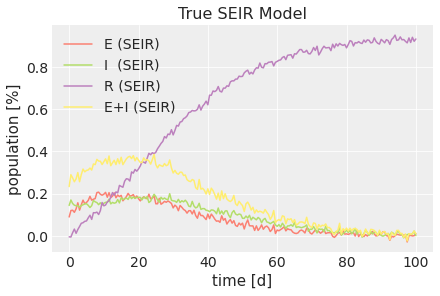

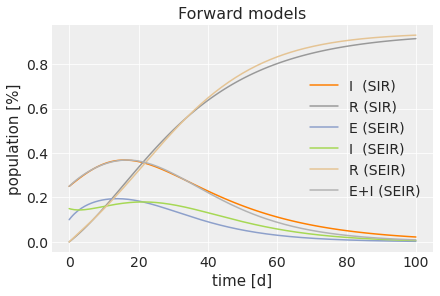

[0.0015473365783691406, 0.0022084712982177734]


In [8]:
# Initialise a model

model_true = Dynamical_System_SEIR(sigma_true, gamma_true, beta_true, days, time_step, initN, initE, initI, initR, np.sqrt(noise_variance_true))

# Plot the true PDE solution and the signal (data)

plt.figure()

model_true.plot_model()

plt.title('True SEIR Model')
plt.legend(loc = 'best')

plt.show()


# Initialize the forward models, according to the time-step refinement degrees

my_models = []

for i in range(len(time_step_models)):

    if(system_models[i] == 'SIR' ):
        my_models.append(Dynamical_System_Forward_SIR (days, time_step_models[i], initN, initE, initI, initR, var_lik[i]))

    if(system_models[i] == 'SEIR'):
        my_models.append(Dynamical_System_Forward_SEIR(days, time_step_models[i], initN, initE, initI, initR, var_lik[i]))


# Plot the solutions and compare meshes

my_models_time = []
plt.figure()

for i,current_model in enumerate(my_models):

    begin = time.time()
    current_model.solve(beta_true, sigma_true, gamma_true)
    my_models_time.append(time.time()-begin)

    current_model.plot_model()

plt.title('Forward models')
plt.legend(loc = 'best')

plt.show()

print(my_models_time)

## Define a Theano Op for the likelihood

In [9]:
# Define log likelihood for a SIR forward model model

def loglik_SIR (my_model, beta_random, sigma_random, gamma_random, model_true):

    my_model.solve(beta_random, sigma_random, gamma_random)

    return -np.sum((my_model.R_interpolated(model_true.time_grid) -  model_true.R              )**2)/ (2 * my_model.var_lik  ) \
           -np.sum((my_model.I_interpolated(model_true.time_grid) - (model_true.E+model_true.I))**2)/ (2 * my_model.var_lik*2)

# Define log likelihood for a SEIR model

def loglik_SEIR(my_model, beta_random, sigma_random, gamma_random, model_true):

    my_model.solve(beta_random, sigma_random, gamma_random)

    return -np.sum(np.linalg.norm(my_model.sol_interpolated(model_true.time_grid) - model_true.data, axis = 1)**2) / (2 * my_model.var_lik)

In [ ]:
# Define Theano operation class to compute custom log likelihood

class LogLike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, model_true, pymc3_model): # add inputs as class attributes

        self.my_model    = my_model
        self.likelihood  = loglike
        self.model_true  = model_true
        self.pymc3_model = pymc3_model

    
    def perform(self, node, inputs, outputs):          # the method that is used when calling the Op
        
        # Store random parameters
        (params,) = inputs 

        # Calculate the likelihood value
        outputs[0][0] = np.array(self.likelihood(self.my_model, params[0], params[1], params[2], self.model_true))

        # Save the quantity of interest to the pymc3 model variable Q
        self.pymc3_model.Q.set_value(QoI(self.my_model))

In [ ]:
# Set up models in PyMC3 for each level

logl          = []
coarse_models = []
fine_model    = []


for j in range(len(time_step_models)):

    with pm.Model() as model:

        # Quantity of Interest Q

        Q = pm.Data("Q", np.ndarray(shape=(n_qoi,), buffer=np.zeros(n_qoi)))
        
        # Priors

        beta_random  = pm.Uniform(name = 'beta_random',  lower = lower_beta,  upper = upper_beta )
        sigma_random = pm.Uniform(name = 'sigma_random', lower = lower_sigma, upper = upper_sigma)
        gamma_random = pm.Uniform(name = 'gamma_random', lower = lower_gamma, upper = upper_gamma)
        
        params = tt.as_tensor_variable([beta_random, sigma_random, gamma_random])

        # Loglikelihood

        if(my_models[j].ODE_label == 'SIR'):
          logl.append(LogLike(my_models[j], loglik_SIR,  model_true, model))

        if(my_models[j].ODE_label == 'SEIR'):
          logl.append(LogLike(my_models[j], loglik_SEIR, model_true, model))

        pm.Potential("likelihood", logl[j](params))

    if(j+1 < len(time_step_models)):
      coarse_models.append(model)
    else:
      fine_model.append(model)

# Perform Inference

In [ ]:
method_names = []
traces       = []
runtimes     = []
colors       = []

with fine_model[0]:

    # Set the starting point for sampling

    if(use_MAP_as_start):
        starting_point = pm.find_MAP(method = 'Powell')

    else:
        starting_point = {'beta_random': beta_0, 'sigma_random': sigma_0, 'gamma_random': gamma_0}

    print('Starting point: ', starting_point)

    # Perform M

    if(perform_M):

        step_M = pm.Metropolis(tune          = tune, 
                               tune_interval = tune_interval_M)


        t_start = time.time()

        trace_M = pm.sample(draws                = ndraws_M,
                            step                 = step_M,
                            chains               = nchains_M,
                            tune                 = nburn_M,
                            discard_tuned_samples= discard_tuning,
                            random_seed          = RANDOM_SEED,
                            start                = starting_point,
                            cores                = 1)

        runtime_M = time.time() - t_start

        method_names.append('Metropolis')
        traces.append(trace_M)
        runtimes.append(runtime_M)
        colors.append('deepskyblue')

    
    # Perform DEMetropolisZ

    if(perform_DMZ):

        step_DMZ = pm.DEMetropolisZ(tune_interval=tune_interval_DMZ)

        t_start = time.time()

        trace_DMZ = pm.sample(draws                = ndraws_DMZ,
                              step                 = step_DMZ,
                              chains               = nchains_DMZ,
                              tune                 = nburn_DMZ,
                              discard_tuned_samples= discard_tuning,
                              random_seed          = RANDOM_SEED,
                              start                = starting_point,
                              cores                = 1)

        runtime_DMZ = time.time() - t_start

        method_names.append('DEMetropolisZ')
        traces.append(trace_DMZ)
        runtimes.append(runtime_DMZ)
        colors.append('blue')



    # Perform MLDA

    if(perform_MLDA_without_variance_reduction):
        
        ## MLDA without variance reduction

        step_MLDA = pm.MLDA(coarse_models      = coarse_models,
                            subsampling_rates  = nsub_MLDA,
                            base_tune_interval = tune_interval_DMZ,
                            variance_reduction = False,
                            store_Q_fine       = True)
        
        t_start = time.time()

        trace_MLDA_without_variance_reduction = pm.sample(draws                = ndraws_MLDA,
                                                          step                 = step_MLDA,
                                                          chains               = nchains_MLDA,
                                                          tune                 = nburn_MLDA,
                                                          discard_tuned_samples= discard_tuning,
                                                          random_seed          = RANDOM_SEED,
                                                          cores                = 1,
                                                          start                = starting_point)

        runtime_MLDA_without_VR = time.time() - t_start

        method_names.append('MLDA without VR')
        traces.append(trace_MLDA_without_variance_reduction)
        runtimes.append(runtime_MLDA_without_VR)
        colors.append('red')


    if(perform_MLDA_with_variance_reduction): 

        ## MLDA with variance reduction

        step_MLDA = pm.MLDA(coarse_models      = coarse_models,
                            subsampling_rates  = nsub_MLDA,
                            base_tune_interval = tune_interval_DMZ,
                            variance_reduction = True)

        t_start = time.time()

        trace_MLDA_with_variance_reduction = pm.sample(draws                = ndraws_MLDA,
                                                       step                 = step_MLDA,
                                                       chains               = nchains_MLDA,
                                                       tune                 = nburn_MLDA,
                                                       discard_tuned_samples= discard_tuning,
                                                       random_seed          = RANDOM_SEED,
                                                       cores                = 1,
                                                       start                = starting_point)

        runtime_MLDA_with_VR = time.time() - t_start

        method_names.append('MLDA with VR')
        traces.append(trace_MLDA_with_variance_reduction)
        runtimes.append(runtime_MLDA_with_VR)
        colors.append('darkorange')

Starting point:  {'beta_random': 0.3, 'sigma_random': 0.25, 'gamma_random': 0.15}


Sequential sampling (3 chains in 1 job)
CompoundStep
>Metropolis: [gamma_random]
>Metropolis: [sigma_random]
>Metropolis: [beta_random]


Sampling 3 chains for 2_000 tune and 8_000 draw iterations (6_000 + 24_000 draws total) took 318 seconds.
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (3 chains in 1 job)
DEMetropolisZ: [gamma_random, sigma_random, beta_random]


Sampling 3 chains for 2_000 tune and 8_000 draw iterations (6_000 + 24_000 draws total) took 107 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Sequential sampling (3 chains in 1 job)
MLDA: [gamma_random, sigma_random, beta_random]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


# Visualize summary quantities

In [ ]:
# Summary quantities

ess          = []  # collect ESS
ess_n        = []  # collect ESS normalized wrt number of samples
acc          = []  # collect acceptance rates
performances = []  # collect ESS per second

with model:

    for i, trace in enumerate(traces):

        print(f"\n{method_names[i]} Sampler:\n")
        print('beta:    ', beta_true)
        print('sigma:   ', sigma_true)
        print('gamma:   ', gamma_true)
        display(pm.stats.summary(trace))

        ess.append  (np.array(pm.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        acc.append  (trace.get_sampler_stats('accepted').mean())
        performances.append(ess[i] / runtimes[i])

        print(f"\n{method_names[i]} Sampler:\n"
              f'\nAcceptance rate:     {acc[i]}'
              f'\nRuntime:             {runtimes[i]} seconds'
              f'\nESS list:            {ess[i]}'
              f'\nNormalised ESS list: {ess_n[i]}'
              f'\nESS/sec:             {performances[i]}\n\n\n')


Metropolis Sampler:

beta:     0.27
sigma:    0.1
gamma:    0.1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_random,0.281,0.033,0.225,0.348,0.001,0.001,672.0,1154.0,1.0
sigma_random,0.101,0.015,0.076,0.130,0.001,0.000,762.0,1510.0,1.0
gamma_random,0.104,0.013,0.082,0.128,0.000,0.000,1061.0,1671.0,1.0



Metropolis Sampler:

Acceptance rate:     0.20434722222222224
Runtime:             320.8002395629883 seconds
ESS list:            [ 672.12838044  761.97211752 1061.22536795]
Normalised ESS list: [0.02800535 0.03174884 0.04421772]
ESS/sec:             [2.09516172 2.37522303 3.30805666]




DEMetropolisZ Sampler:

beta:     0.27
sigma:    0.1
gamma:    0.1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_random,0.278,0.032,0.221,0.339,0.001,0.001,1653.0,2080.0,1.0
sigma_random,0.102,0.015,0.075,0.129,0.000,0.000,1579.0,2186.0,1.0
gamma_random,0.103,0.012,0.081,0.125,0.000,0.000,1893.0,2766.0,1.0



DEMetropolisZ Sampler:

Acceptance rate:     0.45891666666666664
Runtime:             107.66527390480042 seconds
ESS list:            [1653.38010429 1579.27734669 1893.34747437]
Normalised ESS list: [0.06889084 0.06580322 0.07888948]
ESS/sec:             [15.35667021 14.6684004  17.58549814]




MLDA without VR Sampler:

beta:     0.27
sigma:    0.1
gamma:    0.1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_random,0.280,0.033,0.222,0.342,0.001,0.0,3802.0,4262.0,1.0
sigma_random,0.101,0.015,0.075,0.129,0.000,0.0,3296.0,3090.0,1.0
gamma_random,0.103,0.012,0.081,0.126,0.000,0.0,4457.0,6029.0,1.0



MLDA without VR Sampler:

Acceptance rate:     0.328875
Runtime:             1131.3791341781616 seconds
ESS list:            [3801.76860847 3295.9772717  4457.08487142]
Normalised ESS list: [0.15840703 0.13733239 0.18571187]
ESS/sec:             [3.36029585 2.91323852 3.93951482]




MLDA with VR Sampler:

beta:     0.27
sigma:    0.1
gamma:    0.1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_random,0.279,0.034,0.221,0.346,0.001,0.0,3294.0,3802.0,1.0
sigma_random,0.102,0.015,0.075,0.129,0.000,0.0,3143.0,3971.0,1.0
gamma_random,0.103,0.013,0.080,0.126,0.000,0.0,3657.0,4566.0,1.0



MLDA with VR Sampler:

Acceptance rate:     0.31433333333333335
Runtime:             1107.939017534256 seconds
ESS list:            [3294.4474553  3142.81208697 3657.12765461]
Normalised ESS list: [0.13726864 0.1309505  0.15238032]
ESS/sec:             [2.97349168 2.83662913 3.3008384 ]





# Plot ESS and ESS per second quantities

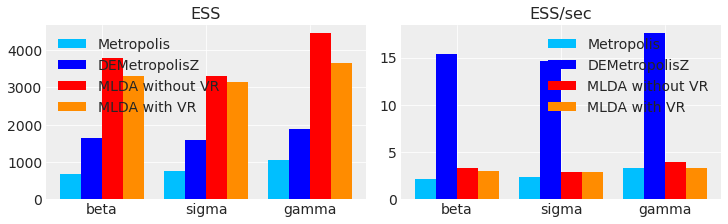

In [ ]:
# Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies

with model:

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].set_title("ESS")
    for i, e in enumerate(ess):
        axes[0].bar(
                    [j + i * 0.2 for j in range(n_params)],
                    e.ravel(),
                    width=0.2,
                    color=colors[i],
                    label=method_names[i],
                    )
    axes[0].set_xticks([i + 0.3 for i in range(n_params)])
    axes[0].set_xticklabels(["beta", "sigma", "gamma"])
    axes[0].legend()

    axes[1].set_title("ESS/sec")
    for i, p in enumerate(performances):
        axes[1].bar(
                    [j + i * 0.2 for j in range(n_params)],
                    p.ravel(),
                    width=0.2,
                    color=colors[i],
                    label=method_names[i],
                    )
    axes[1].set_xticks([i + 0.3 for i in range(n_params)])
    axes[1].set_xticklabels(["beta", "sigma", "gamma"])
    axes[1].legend()
    plt.show()
    fig.savefig('ESS_Comparison.png')

# Plot traces and posteriors

Metropolis


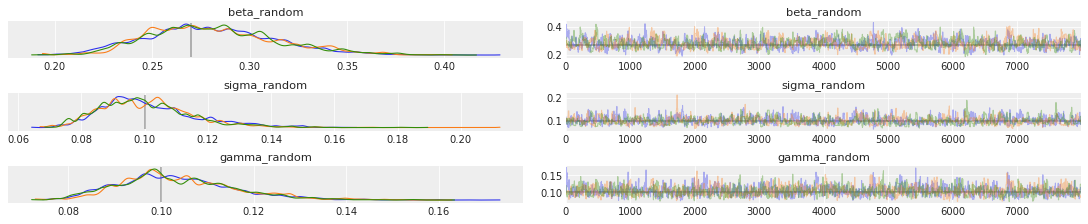





DEMetropolisZ


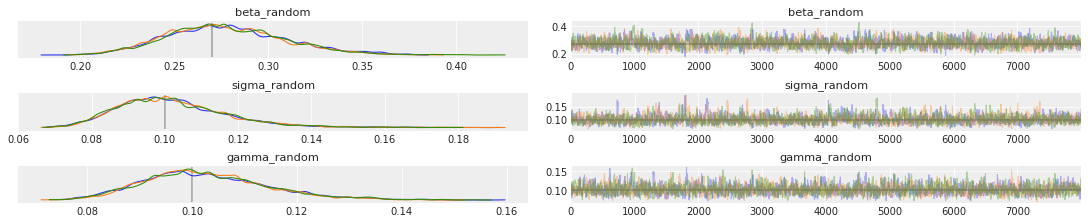





MLDA without VR


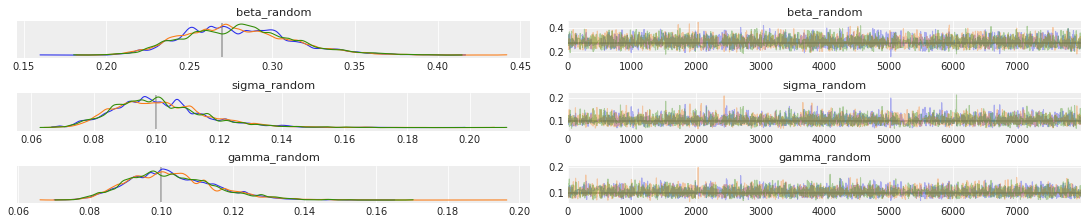





MLDA with VR


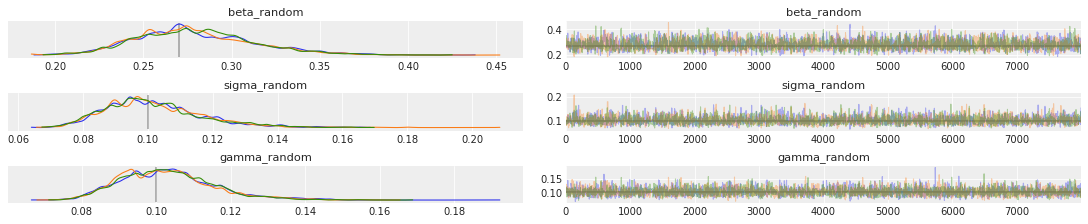

In [ ]:
# Plot traces and posteriors

with model:
    
    lines = [('beta_random', {}, beta_true), ('sigma_random', {}, sigma_true), ('gamma_random', {}, gamma_true)]

    for i, trace in enumerate(traces):
        print(method_names[i])
        ax2  = az.plot_trace(trace, lines=lines, figsize=(15,3), compact=False)
        fig2 = ax2.ravel()[0].figure
        plt.show()
        fig2.savefig("Output_" + str(method_names[i]) + '.png')
        print('\n\n\n')

# Plot autocorrelation

Got error No model on context stack. trying to find log_likelihood in translation.


Metropolis


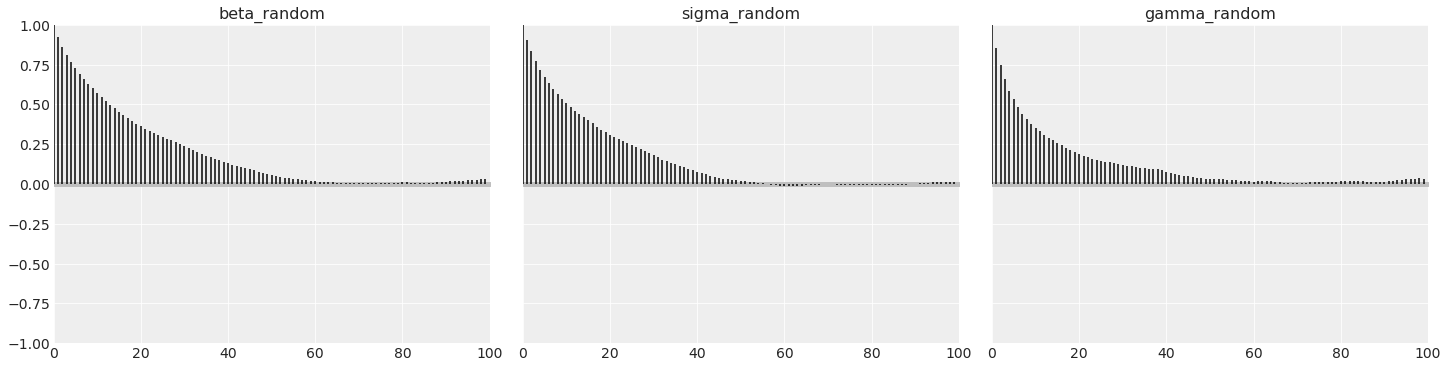

Got error No model on context stack. trying to find log_likelihood in translation.






DEMetropolisZ


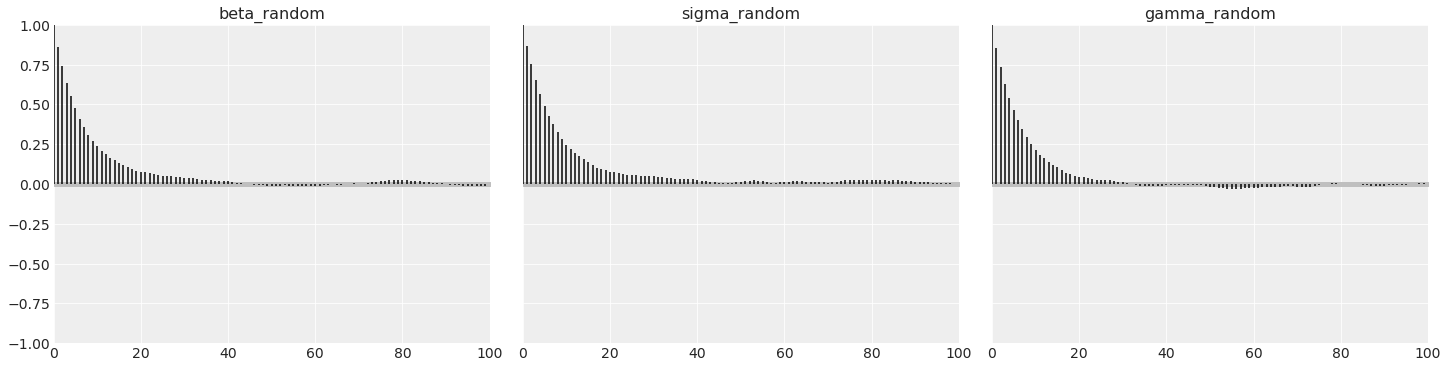

Got error No model on context stack. trying to find log_likelihood in translation.






MLDA without VR


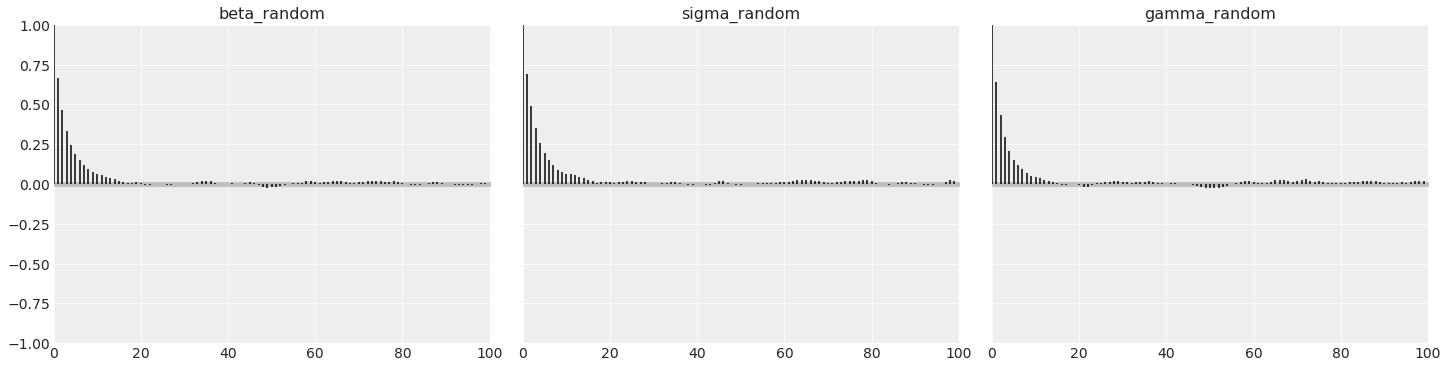

Got error No model on context stack. trying to find log_likelihood in translation.






MLDA with VR


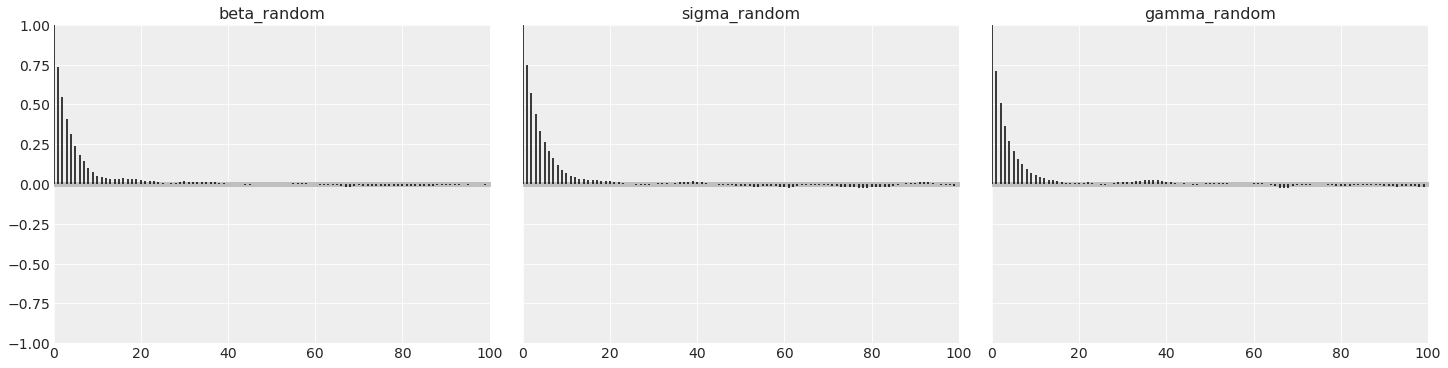

In [ ]:
# Plot autocorrelation

for i, trace in enumerate(traces):
    print(method_names[i])
    ax3  = az.plot_autocorr(trace, figsize=(20,5), combined=True)
    fig3 = ax3.ravel()[0].figure
    plt.show()
    fig3.savefig("Autocorr_" + str(method_names[i]) + '.png')
    print('\n\n\n')

# Plot likelihood

In [10]:
def compute_loglik(k, l, beta_range, sigma_range, gamma_range):
  
  if(k==0):
    
    sigma_test, gamma_test = np.meshgrid(sigma_range, gamma_range)

    loglik_test = np.ones(shape = sigma_test.shape)

    for i in range(len(sigma_test)):
      for j in range(len(sigma_test)):
        if(l==0):
          loglik_test[i][j] = loglik_SIR (my_models[l], beta_true, sigma_test[i][j], gamma_test[i][j], model_true)
        else:
          loglik_test[i][j] = loglik_SEIR(my_models[l], beta_true, sigma_test[i][j], gamma_test[i][j], model_true)


    return loglik_test, 'sigma', 'gamma', sigma_true, gamma_true, sigma_range, gamma_range
  
  if(k==1):

    beta_test, gamma_test = np.meshgrid(beta_range, gamma_range)

    loglik_test = np.ones(shape = beta_test.shape)

    for i in range(len(beta_test)):
      for j in range(len(beta_test)):
        
        if(l==0):
          loglik_test[i][j] = loglik_SIR (my_models[l], beta_test[i][j], sigma_true, gamma_test[i][j], model_true)
        else:
          loglik_test[i][j] = loglik_SEIR(my_models[l], beta_test[i][j], sigma_true, gamma_test[i][j], model_true)


    return loglik_test, 'beta', 'gamma', beta_true, gamma_true, beta_range, gamma_range

  
  if(k==2):

    beta_test, sigma_test = np.meshgrid(beta_range, sigma_range)

    loglik_test = np.ones(shape = beta_test.shape)

    for i in range(len(beta_test)):
      for j in range(len(beta_test)):
        
        if(l==0):
          loglik_test[i][j] = loglik_SIR (my_models[l], beta_test[i][j], sigma_test[i][j], gamma_true, model_true)
        else:
          loglik_test[i][j] = loglik_SEIR(my_models[l], beta_test[i][j], sigma_test[i][j], gamma_true, model_true)

    return loglik_test, 'beta', 'sigma', beta_true, sigma_true, beta_range, sigma_range

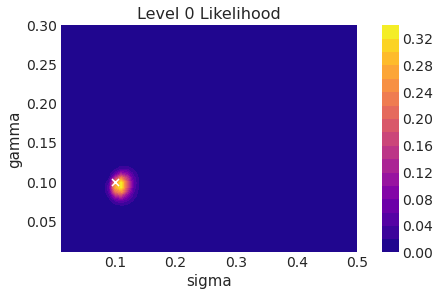

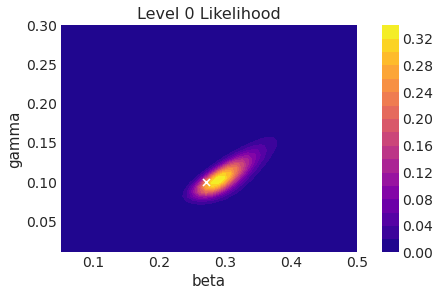

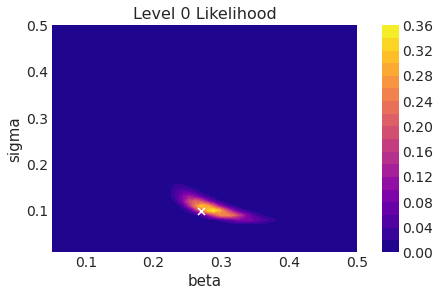

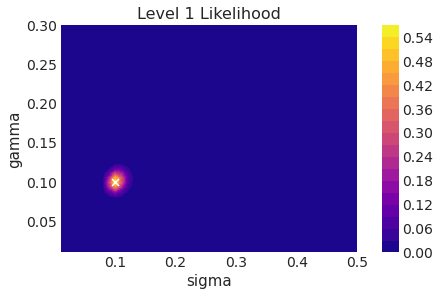

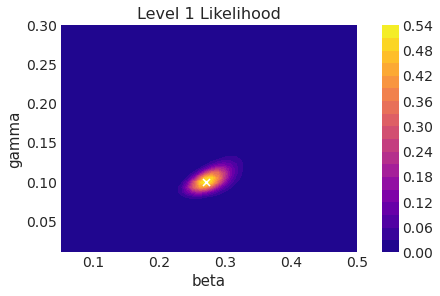

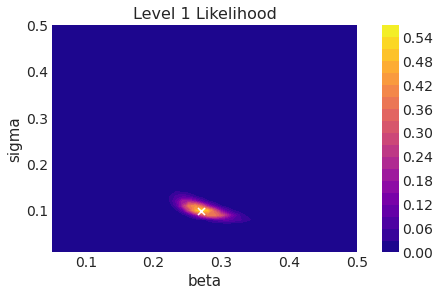

In [12]:
# Likelihood as a function of the random parameters

if (plot_likelihood):

    if(plot_customized_lik):
      beta_range  = np.linspace(1.0,  1.2,  n_ref_lik)
      gamma_range = np.linspace(0.27, 0.32, n_ref_lik)
      sigma_range = np.linspace(0.18, 0.22, n_ref_lik)
    else:
      beta_range  = np.linspace(lower_beta,  upper_beta,  n_ref_lik)
      gamma_range = np.linspace(lower_gamma, upper_gamma, n_ref_lik)
      sigma_range = np.linspace(lower_sigma, upper_sigma, n_ref_lik)

    for l in range(len(var_lik)):

        loglik_test = np.ones(shape = (n_ref_lik, n_ref_lik))

        for k in range(n_params):

          loglik_test, xlabel, ylabel, true1, true2, test1, test2 = compute_loglik(k, l, beta_range, sigma_range, gamma_range)

          sf = plt.contourf(test1, test2, np.exp(loglik_test), contour_lik, cmap='plasma')
          plt.scatter(true1, true2, marker='x', s = 50, c='white')
          plt.colorbar(sf)
          plt.title('Level ' + str(l) + ' Likelihood')
          plt.xlabel(xlabel)
          plt.ylabel(ylabel)
          plt.savefig("Likelihood" + str(l) + "_" + xlabel + "_" + ylabel + ".png")
          plt.show()

# Estimate Standard Errors of the methods

In [ ]:
# Extract quantities of interest from the traces

## MLDA without VR
if(perform_MLDA_without_variance_reduction):
  Q_1 = trace_MLDA_without_variance_reduction.get_sampler_stats("Q_1").reshape((nchains_MLDA * ndraws_MLDA,)) # Q_i where i=levels-1
  Q_1 = np.array(list(Q_1))


## MLDA with VR
if(perform_MLDA_with_variance_reduction):

  ### PAY ATTENTION ON HOW MANY TIMES YOU HAVE TO MULTIPLY BY NSUB: IT DEPENDS ON THE LEVELS
  Q_0   = np.concatenate(trace_MLDA_with_variance_reduction.get_sampler_stats("Q_0"  )).reshape((nchains_MLDA * ndraws_MLDA * nsub_MLDA, n_qoi)) 
  Q_1_0 = np.concatenate(trace_MLDA_with_variance_reduction.get_sampler_stats("Q_1_0")).reshape((nchains_MLDA * ndraws_MLDA,             n_qoi))


# Estimates

if(perform_MLDA_without_variance_reduction):
  Q_mean_standard = Q_1.mean(axis = 0)
  print(f"Q_1 mean   = {Q_1.mean(axis = 0)}\n")


if(perform_MLDA_with_variance_reduction):
  Q_mean_vr = Q_0.mean(axis=0) + Q_1_0.mean(axis=0)
  print(f"Q_0 mean   = {Q_0.mean(axis=0)}")
  print(f"Q_1_0 mean = {Q_1_0.mean(axis=0)}\n")


if(perform_MLDA_without_variance_reduction):
  print(f"Standard method:    Mean: {Q_mean_standard}\n")


if(perform_MLDA_with_variance_reduction):
  print(f"VR method:          Mean: {Q_mean_vr}\n")


# Calculate variances of Q quantity samples

if(perform_MLDA_without_variance_reduction):
  Q_1_var = Q_1.var(axis=0)
  print(f"Q_1 var   = {Q_1_var}\n")


if(perform_MLDA_with_variance_reduction):
  Q_0_var   = Q_0.var(axis=0)
  Q_1_0_var = Q_1_0.var(axis=0)
  print(f"Q_0 var   = {Q_0_var}")
  print(f"Q_1_0_var = {Q_1_0_var}\n")

Q_1 mean   = [18.98352083  0.17975788]

Q_0 mean   = [15.62814167  0.37904174]
Q_1_0 mean = [ 3.38497917 -0.18992805]

Standard method:    Mean: [18.98352083  0.17975788]

VR method:          Mean: [19.01312083  0.1891137 ]

Q_1 var   = [4.19826972e+01 4.35839085e-04]

Q_0 var   = [1.12088805e+00 7.71730986e-04]
Q_1_0_var = [3.67119265e+01 5.76708343e-04]



In [ ]:
## Calculate standard error of each term using ESS

if(perform_MLDA_without_variance_reduction):

  ess_Q1 = np.zeros(n_qoi)
  for i in range(n_qoi):
    ess_Q1[i] = az.ess(np.array(Q_1[:,i], np.float64))

  print("Without VR ESS:  ", ess_Q1)

  # Standard Error Estimate
  print("Without VR Standard Error: ", Q_1_var/ess_Q1)

if(perform_MLDA_with_variance_reduction):

  # note that the chain in level 1 has much fewer samples than the chain in level 0 (because of the subsampling rates)
  ess_Q0    = np.zeros(n_qoi)
  ess_Q_1_0 = np.zeros(n_qoi)
  for i in range(n_qoi):
    ess_Q0[i]    = az.ess(np.array(Q_0  [:,i], np.float64))
    ess_Q_1_0[i] = az.ess(np.array(Q_1_0[:,i], np.float64))

  print("With VR ESS:     ", ess_Q0, ess_Q_1_0)

  # Standard Error Estimates
  print("With VR Standard Errors:   ", Q_0_var/ess_Q0,'   ', Q_1_0_var/ess_Q_1_0)

Without VR ESS:   [3028.44832003 3033.37165013]
Without VR Standard Error:  [1.38627748e-02 1.43681400e-07]
With VR ESS:      [12961.12759438 11295.55307645] [2869.41956122 3209.84882675]
With VR Standard Errors:    [8.64807509e-05 6.83216644e-08]     [1.27941995e-02 1.79668381e-07]


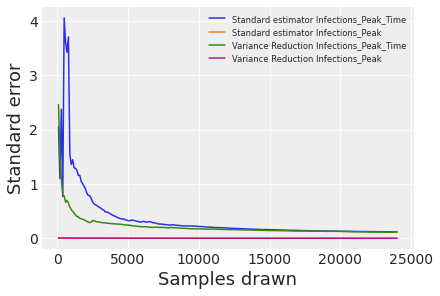

In [ ]:
## Calculate total standard errors of the two competing estimates with different chunks of the sample

from matplotlib.ticker import ScalarFormatter

step = 100  # 100

if(perform_MLDA_without_variance_reduction):
  Q1_SE         = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  E_standard_SE = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))


if(perform_MLDA_with_variance_reduction):
  Q0_SE    = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  Q_1_0_SE = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  E_VR_SE  = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))

k = 0

for i in np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step):

  for q in range(n_qoi):      

    try:
      Q1_SE[k,q] = Q_1[0:i, q].var(axis=0) / az.ess(np.array(Q_1[0:i,q], np.float64))
      E_standard_SE[k,q] = np.sqrt(Q1_SE[k,q])
    except:
      pass

    try:
      Q0_SE   [k,q] = Q_0  [0 : i * nsub_MLDA, q].var(axis=0) / az.ess(np.array(Q_0  [0 : i * nsub_MLDA,q], np.float64))
      Q_1_0_SE[k,q] = Q_1_0[0 : i,             q].var(axis=0) / az.ess(np.array(Q_1_0[0 : i,            q], np.float64))
      E_VR_SE [k,q] = np.sqrt(Q0_SE[k,q] + Q_1_0_SE[k,q])
    except:
      pass

  k += 1

fig = plt.figure()
ax  = fig.gca()
legend_strings = []

for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

if(perform_MLDA_without_variance_reduction):
  ax.plot(np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step), E_standard_SE)
  legend_strings.append(f"Standard estimator {qoi_names[0]}")
  legend_strings.append(f"Standard estimator {qoi_names[1]}")


if(perform_MLDA_with_variance_reduction):
  ax.plot(np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step), E_VR_SE)
  legend_strings.append(f"Variance Reduction {qoi_names[0]}")
  legend_strings.append(f"Variance Reduction {qoi_names[1]}")

ax.legend(legend_strings, fontsize = "small")

plt.xlabel("Samples drawn",  fontsize=18)
plt.ylabel("Standard error", fontsize=18)

plt.savefig('Standard_Error.png')
plt.show()

In [ ]:
def compute_QoI_M_DMZ(trace, level_L_model, n_qoi):

    # Compute QoI traces

    n_samples = len(trace['beta_random'])
    QoI_trace = np.zeros((n_samples,n_qoi))

    for i in range(n_samples):

        level_L_model.solve(trace['beta_random'] [i],
                            trace['sigma_random'][i],
                            trace['gamma_random'][i])

        QoI_trace[i,:] = QoI(level_L_model)

    # Compute sampling statistics

    QoI_mean = QoI_trace.mean(axis = 0)
    QoI_var  = QoI_trace.var (axis = 0)

    QoI_ESS  = np.zeros(n_qoi)
    
    for i in range(n_qoi):
        QoI_ESS[i] = az.ess(np.array(QoI_trace[:,i], np.float64))

    return QoI_trace, QoI_mean, QoI_var, QoI_ESS

In [ ]:
if (perform_M):

    QoI_trace_MH, QoI_mean_MH, QoI_var_MH, QoI_ESS_MH = compute_QoI_M_DMZ(trace_M, my_models[-1], n_qoi)

    print("Metropolis Mean:           ", QoI_mean_MH)
    print("Metropolis  Var:           ", QoI_var_MH)
    print("Metropolis  ESS:           ", QoI_ESS_MH)

    print("Metropolis Standard Error: ", QoI_var_MH/QoI_ESS_MH)



if (perform_DMZ):

    QoI_trace_DMZ, QoI_mean_DMZ, QoI_var_DMZ, QoI_ESS_DMZ = compute_QoI_M_DMZ(trace_DMZ, my_models[-1], n_qoi)

    print("DEMetropolisZ Mean:           ", QoI_mean_DMZ)
    print("DEMetropolisZ  Var:           ", QoI_var_DMZ)
    print("DEMetropolisZ  ESS:           ", QoI_ESS_DMZ)

    print("DEMetropolisZ Standard Error: ", QoI_var_DMZ/QoI_ESS_DMZ)

Metropolis Mean:            [18.90714583  0.17907292]
Metropolis  Var:            [4.28505969e+01 4.27100024e-04]
Metropolis  ESS:            [2646.50348079 1201.51260886]
Metropolis Standard Error:  [1.61914001e-02 3.55468616e-07]
DEMetropolisZ Mean:            [19.22810417  0.18017031]
DEMetropolisZ  Var:            [3.62913539e+01 4.16654579e-04]
DEMetropolisZ  ESS:            [1971.08315224 1858.08780946]
DEMetropolisZ Standard Error:  [1.84118838e-02 2.24238369e-07]
